## Linear-Exponential Adaptation Model 2 Parameter

In [8]:
'''

Purpose of code is to loop through hazard model data and generate LEA-fitted model based on observed h(t)_filtered_0.9 with 2 parameters.

If you would like to change the filtering, in the source file, there is an option for zero filtering. Please utilize the method that yeilds the most
significant and meaningful results.

INPUT: Hazard_Model_Data_1.csv

OUTPUT: Charts, results dataframe.

'''


import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

df = pd.read_csv('Datasets/Hazard_Model_Data_1.csv')

# 2 parameter hazard function


def hazard_model(t, a_m, p):
    return t * a_m * np.exp(-t / p)


# objective function
def objective(params, t, y_observed):
    a_m, p = params
    y_estimated = hazard_model(t, a_m, p)
    return np.sum((y_observed - y_estimated) ** 2)


states = []
mobility_types = []
a_m_values = []
p_values = []
r2_values = []


for (state, mobility_type), group in df.groupby(['state', 'mobility_type']):
    t = np.array(np.arange(len(group['t'])))
    y_observed = group['h(t)_filtered_0.9'].values

    init_params = [0.1, 10]

    res = minimize(objective, init_params, args=(
        t, y_observed), bounds=((0, None), (0.00000001, None)))
    a_m_estimated, p_estimated = res.x

    y_predicted = hazard_model(t, a_m_estimated, p_estimated)

    SSR = np.sum((y_observed - y_predicted) ** 2)
    SST = np.sum((y_observed - np.mean(y_observed)) ** 2)
    R2 = 1 - (SSR / SST)

    '''plt.figure(figsize=(10, 6))
    plt.plot(t, y_observed, 'o-', label='Observed')
    plt.plot(t, hazard_model(t, a_m_estimated, p_estimated),
             'x-', label='Fitted Hazard Model')
    plt.xlabel('t')
    plt.ylabel('h(t)')
    plt.title(f'Observed vs. Fitted Hazard Model for {state}, {mobility_type}')
    plt.legend()
    plt.grid(True)
    plt.show()'''

    states.append(state)
    mobility_types.append(mobility_type)
    a_m_values.append(a_m_estimated)
    p_values.append(p_estimated)
    r2_values.append(R2)

results_df = pd.DataFrame({
    'State': states,
    'Mobility Type': mobility_types,
    'a_m': a_m_values,
    'p': p_values,
    'R^2': r2_values
})

results_df.to_csv("Results/LEA_2.csv")


## Linear-Exponential Adaptation Model 3 Parameter

In [1]:
'''

Purpose of code is to loop through hazard model data and generate LEA-fitted model based on observed h(t)_filtered_0.9 with 3 parameters.

If you would like to change the filtering, in the source file, there is an option for zero filtering. Please utilize the method that yeilds the most
significant and meaningful results.

INPUT: Hazard_Model_Data_1.csv

OUTPUT: Charts, results dataframe.

'''

import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Read the data
df = pd.read_csv('Datasets/Hazard_Model_Data_1.csv')

# Define the custom hazard function


def hazard_model(t, a, s, p):
    return a * t * np.exp(- (t / p)**s * (1/s))

# Objective function for fitting


def objective(params, t, y_observed):
    a, s, p = params
    y_estimated = hazard_model(t, a, s, p)
    return np.sum((y_observed - y_estimated) ** 2)


# Initialize empty lists to store results
states = []
mobility_types = []
a_values = []
p_values = []
s_values = []
r2_values = []

# Loop over unique combinations of state and mobility_type
for (state, mobility_type), group in df.groupby(['state', 'mobility_type']):
    t = np.array(np.arange(len(group['t'])))
    y_observed = group['h(t)_filtered_0.9'].values

    # Initial guesses for a, s, and p
    init_params = [y_observed[0], 1, t[np.argmax(y_observed)]]

    # Perform optimization to fit the custom hazard model
    res = minimize(objective, init_params, args=(t, y_observed),
                   bounds=((0, None), (0.1, 26.98240641), (0.00000001, None)))  # Note: upper bound for s is determined by top 5% of s
    a_estimated, s_estimated, p_estimated = res.x

    y_predicted = hazard_model(t, a_estimated, s_estimated, p_estimated)

    # Calculate R^2
    SSR = np.sum((y_observed - y_predicted) ** 2)
    SST = np.sum((y_observed - np.mean(y_observed)) ** 2)
    R2 = 1 - (SSR / SST)

    # Plot the observed data and the fitted hazard model curve
    '''plt.figure(figsize=(10, 6))
    plt.plot(t, y_observed, 'o-', label='Observed')
    plt.plot(t, hazard_model(t, a_estimated, s_estimated,
             p_estimated), 'x-', label='Fitted Hazard Model')
    plt.axvline(p_estimated, color='r', linestyle='--',
                label=f'Peak at t={p_estimated:.5f}')
    plt.xlabel('t')
    plt.ylabel('h(t)')
    plt.title(f'Observed vs. Fitted Hazard Model for {state}, {mobility_type}')
    plt.legend()
    plt.grid(True)

    # Display values of a, s, p, and R^2
    plt.text(0.7 * t[-1], 0.7 * max(y_observed), f'a = {a_estimated:.5f}\ns = {s_estimated:.5f}\np = {p_estimated:.5f}\nR^2 = {R2:.5f}',
             fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    plt.show()'''

    states.append(state)
    mobility_types.append(mobility_type)
    a_values.append(a_estimated)
    p_values.append(p_estimated)
    s_values.append(s_estimated)
    r2_values.append(R2)

# Compile results into a dataframe
results_df = pd.DataFrame({
    'State': states,
    'Mobility Type': mobility_types,
    'a': a_values,
    'p': p_values,
    's': s_values,
    'R^2': r2_values
})

results_df.to_csv("Results/LEA_3.csv")


## LEA 3 Detailed Results Output

In [10]:
'''

Purpose of code is to export a detailed profile of h(t) fit by the LEA model. 

'''


import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Read the data
df = pd.read_csv('Datasets/Hazard_Model_Data_1.csv')


def hazard_model(t, a, s, p):
    return a * t * np.exp(- (t / p)**s * (1/s))


def objective(params, t, y_observed):
    a, s, p = params
    y_estimated = hazard_model(t, a, s, p)
    return np.sum((y_observed - y_estimated) ** 2)


detailed_states = []
detailed_mobility_types = []
detailed_t = []
detailed_observed = []
detailed_fitted = []

# Loop over unique combinations of state and mobility_type
for (state, mobility_type), group in df.groupby(['state', 'mobility_type']):
    t = np.array(np.arange(len(group['t'])))
    y_observed = group['h(t)_filtered_0.9'].values

    # Initial guesses for a, s, and p
    init_params = [y_observed[0], 1, t[np.argmax(y_observed)]]

    res = minimize(objective, init_params, args=(t, y_observed),
                   bounds=((0, None), (0.1, 26.98240641), (0.00000001, None)))  # Note: upper bund for s is determined by top 5% of s
    a_estimated, s_estimated, p_estimated = res.x

    y_predicted = hazard_model(t, a_estimated, s_estimated, p_estimated)

    detailed_states.extend([state] * len(t))
    detailed_mobility_types.extend([mobility_type] * len(t))
    detailed_t.extend(t)
    detailed_observed.extend(y_observed)
    detailed_fitted.extend(y_predicted)

detailed_df = pd.DataFrame({
    'State': detailed_states,
    'Mobility Type': detailed_mobility_types,
    't': detailed_t,
    'Observed h(t)': detailed_observed,
    'Fitted h(t)': detailed_fitted
})

detailed_df.to_csv('Results/fitted_hazard_detailed.csv')


## Weibull

In [7]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Read the data
df = pd.read_csv('Datasets/Hazard_Model_Data_1.csv')

# Define the Weibull function


def weibull(t, A, B):
    return B / A * (t / A) ** (B - 1)

# Define the objective function for fitting


def objective(params, t, y_observed):
    A, B = params
    y_estimated = weibull(t, A, B)
    return np.sum((y_observed - y_estimated) ** 2)


# Create an empty dataframe to store results
results_df = pd.DataFrame(columns=['state', 'mobility_type', 'A', 'B', 'R2'])

# Loop over unique combinations of state and mobility_type
for (state, mobility_type), group in df.groupby(['state', 'mobility_type']):

    t = np.array(np.arange(len(group['t'])))
    y_observed = group['h(t)_filtered_0.9'].values

    # Initial guesses for A and B
    init_params = [1, 1]

    # Perform optimization to fit the Weibull distribution
    res = minimize(objective, init_params, args=(t, y_observed))
    A_estimated, B_estimated = res.x

    y_predicted = weibull(t, A_estimated, B_estimated)

    # Calculate R^2
    SSR = np.sum((y_observed - y_predicted) ** 2)
    SST = np.sum((y_observed - np.mean(y_observed)) ** 2)
    R2 = 1 - (SSR / SST)

    # Add results to dataframe
    results_df = results_df.append({'state': state, 'mobility_type': mobility_type,
                                   'A': A_estimated, 'B': B_estimated, 'R2': R2}, ignore_index=True)

    # Plot the observed data and the fitted Weibull curve
    '''plt.figure(figsize=(10, 6))
    plt.plot(t, y_observed, 'o-', label='Observed')
    plt.plot(t, weibull(t, A_estimated, B_estimated), 'x-', label='Fitted Weibull')
    plt.xlabel('t')
    plt.ylabel('h(t)')
    plt.title(f'Observed vs. Fitted Weibull Distribution for {state}, {mobility_type}')
    plt.legend()
    plt.grid(True)
    plt.show()'''

# Display the results
print(results_df)
results_df.to_csv('Results/fitted_weibull.csv')


       state                                      mobility_type           A  \
0    Alabama  grocery_and_pharmacy_percent_change_from_baseline   28.841722   
1    Alabama                 parks_percent_change_from_baseline   67.140957   
2    Alabama           residential_percent_change_from_baseline   28.618653   
3    Alabama  retail_and_recreation_percent_change_from_base...   52.439109   
4    Alabama      transit_stations_percent_change_from_baseline   54.717666   
..       ...                                                ...         ...   
307  Wyoming                 parks_percent_change_from_baseline   54.560914   
308  Wyoming           residential_percent_change_from_baseline   28.164201   
309  Wyoming  retail_and_recreation_percent_change_from_base...   33.017786   
310  Wyoming      transit_stations_percent_change_from_baseline   42.401589   
311  Wyoming            workplaces_percent_change_from_baseline  109.767107   

            B        R2  
0    1.249202  0.318761  

In [20]:
import pandas as pd

df = pd.read_csv('Datasets/nhgis0010_ds244_20195_2019_state.csv',
                 encoding='ISO-8859-1', header=1)

filtered_columns = [
    col for col in df if 'State Name' in col or 'Estimate' in col]
filtered_df = df[['State Name'] + filtered_columns]

filtered_df = filtered_df.drop(filtered_df.columns[[0, 1]], axis=1)


filtered_df.to_csv('Datasets/cleaned_nhgis_data.csv')
filtered_df.head()


,Estimates: Area Name,Estimates: Total,Estimates: Male,Estimates: Male: Under 5 years,Estimates: Male: 5 to 9 years,Estimates: Male: 10 to 14 years,Estimates: Male: 15 to 17 years,Estimates: Male: 18 and 19 years,Estimates: Male: 20 years,Estimates: Male: 21 years,...,Estimates: 65 years and over: With one type of health insurance coverage: With VA Health Care only,Estimates: 65 years and over: With two or more types of health insurance coverage,Estimates: 65 years and over: With two or more types of health insurance coverage: With employer-based and direct-purchase coverage,Estimates: 65 years and over: With two or more types of health insurance coverage: With employer-based and Medicare coverage,Estimates: 65 years and over: With two or more types of health insurance coverage: With direct-purchase and Medicare coverage,Estimates: 65 years and over: With two or more types of health insurance coverage: With Medicare and Medicaid/means-tested public coverage,Estimates: 65 years and over: With two or more types of health insurance coverage: Other private only combinations,Estimates: 65 years and over: With two or more types of health insurance coverage: Other public only combinations,Estimates: 65 years and over: With two or more types of health insurance coverage: Other coverage combinations,Estimates: 65 years and over: No health insurance coverage
0,Alabama,4876250,2359355,149090,153494,158617,98257,64980,35870,35040,...,469,556059,473,146211,143044,59733,105,17885,188608,2892
1,Alaska,737068,384915,27062,26776,25921,15200,9746,6154,6029,...,81,58922,114,22763,6211,8492,96,3066,18180,780
2,Arizona,7050299,3504509,221817,228224,241782,142358,99160,53415,52100,...,972,760054,1523,169353,235732,88260,67,39668,225451,10060
3,Arkansas,2999370,1471760,96986,100270,101442,61421,41658,23070,21553,...,394,329324,86,59773,105789,39320,13,19425,104918,2313
4,California,39283497,19526298,1254607,1257974,1318355,779960,529837,295438,285103,...,4245,3461873,6371,977119,766214,846380,863,106623,758303,58120


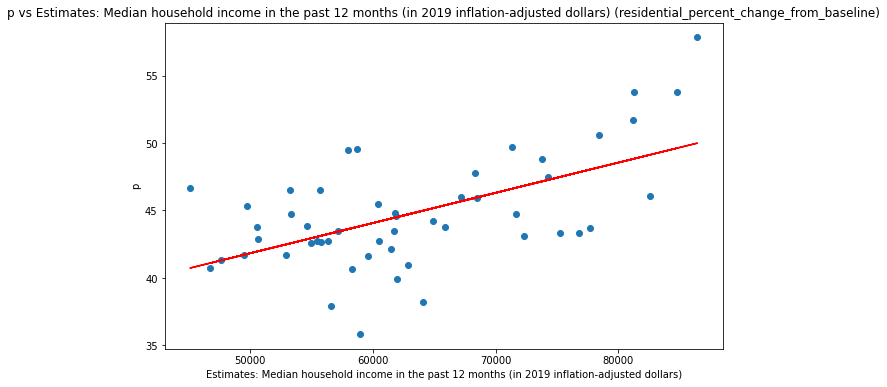

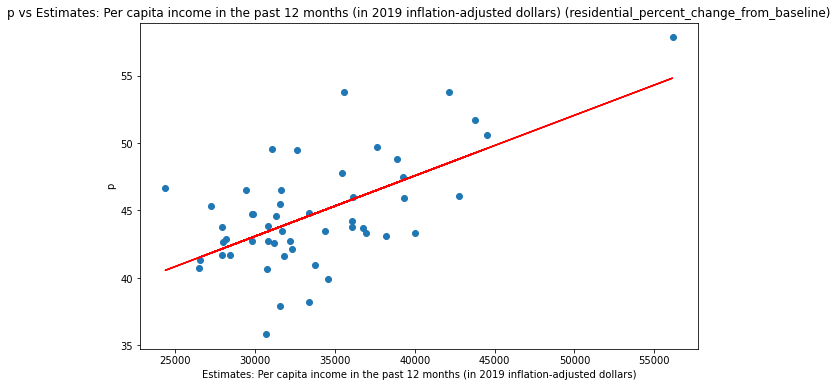

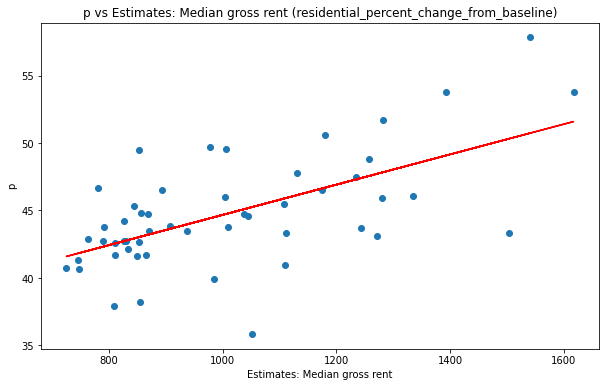

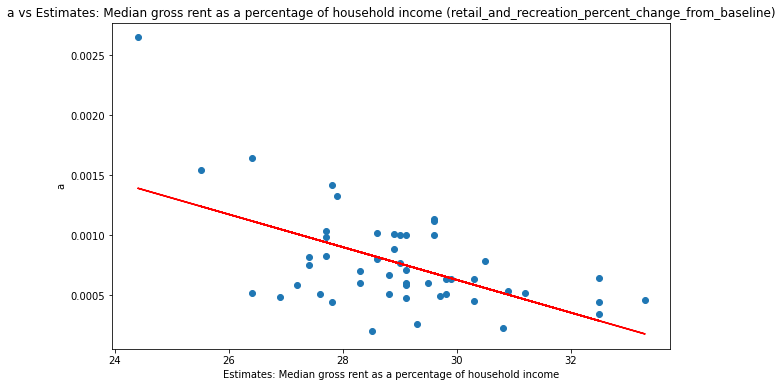

In [67]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

df1 = pd.read_csv('Datasets/cleaned_nhgis_data.csv')

df2 = pd.read_csv('Results/LEA_3.csv')
df2 = df2[df2['State'] != "United States"]


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def run_regression_and_plot(df1, df2, mobility_type, X_column, y_columns, results_list):
    df2_filtered = df2[df2['Mobility Type'] == mobility_type]

    df = pd.merge(df1, df2_filtered,
                  left_on='Estimates: Area Name', right_on='State')

    df = df.drop(columns=['State', 'Mobility Type'])

    X = sm.add_constant(df[[X_column]])

    for y_col in y_columns:
        y = df[y_col]
        model = sm.OLS(y, X)
        results = model.fit()

        y_pred = results.predict(X)
        mape = mean_absolute_percentage_error(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        r2 = r2_score(y, y_pred)

        results_list.append([mobility_type, X_column, y_col, mape, mae, r2])

        if (r2 > 0.3):
            plt.figure(figsize=(10, 6))
            plt.scatter(df[X_column], y)
            plt.plot(df[X_column], y_pred, color='red')
            plt.xlabel(X_column)
            plt.ylabel(y_col)
            plt.title(f'{y_col} vs {X_column} ({mobility_type})')
            plt.show()


X_columns = df1.columns[2:]
y_columns = ['a', 'p', 's']

mobility_types = df2['Mobility Type'].unique()

results_list = []

for mobility_type in mobility_types:
    for X_column in X_columns:
        run_regression_and_plot(df1, df2, mobility_type,
                                X_column, y_columns, results_list)

results_df = pd.DataFrame(results_list, columns=[
                          'Mobility Type', 'X Variable', 'Y Variable', 'MAPE', 'MAE', 'R2'])
results_df.to_csv('regression_results_linear.csv', index=False)


In [66]:
'''import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.optimize import curve_fit

# Load the data
df1 = pd.read_csv('Datasets/cleaned_nhgis_data.csv')

df2 = pd.read_csv('Results/LEA_3.csv')
df2 = df2[df2['State'] != "United States"]


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define the model function (exponential decay)


def model(x, a, b, c):
    return a * np.exp(-b * x) + c

# Define a function to run the regression and plot the results


def run_regression_and_plot(df1, df2, mobility_type, X_column, y_columns, results_list):
    # Filter the data for the specified mobility type
    df2_filtered = df2[df2['Mobility Type'] == mobility_type]

    # Merge the dataframes on the 'State' column
    df = pd.merge(df1, df2_filtered,
                  left_on='Estimates: Area Name', right_on='State')

    # Drop the columns that you don't need
    df = df.drop(columns=['State', 'Mobility Type'])

    # Sort the DataFrame by the X_column values
    df = df.sort_values(by=X_column)

    X = df[X_column].values

    # Scale the X values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.reshape(-1, 1)).flatten()

    p0 = [1, 1, 1]  # initial parameter estimates
    method = 'trf'  # optimization algorithm ('lm', 'trf', or 'dogbox')

    # Loop through each target variable and run the regression
    for y_col in y_columns:
        y = df[y_col]
        try:
            popt, _ = curve_fit(model, X_scaled, y, p0=p0, method=method)
        except RuntimeError:
            print(
                f"Unable to fit model for {mobility_type}, {X_column}, {y_col}")
            return

        y_pred = model(X_scaled, *popt)
        mape = mean_absolute_percentage_error(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        r2 = r2_score(y, y_pred)

        results_list.append([mobility_type, X_column, y_col, mape, mae, r2])

        # Plot the results
        plt.figure(figsize=(10, 6))
        plt.scatter(X, y)
        plt.plot(X, y_pred, color='red')
        plt.xlabel(X_column)
        plt.ylabel(y_col)
        plt.title(f'{y_col} vs {X_column} ({mobility_type})')
        plt.show()


# Define your predictor variables (X) and target variables (y)
X_columns = df1.columns[2:]
y_columns = ['a', 'p', 's']

# Get the unique mobility types
mobility_types = df2['Mobility Type'].unique()

results_list = []

# Run the regression and plot the results for each mobility type and X variable
for mobility_type in mobility_types:
    for X_column in X_columns:
        run_regression_and_plot(df1, df2, mobility_type,
                                X_column, y_columns, results_list)

results_df = pd.DataFrame(results_list, columns=[
                          'Mobility Type', 'X Variable', 'Y Variable', 'MAPE', 'MAE', 'R2'])
results_df.to_csv('regression_results.csv', index=False)
'''


'import pandas as pd\nimport matplotlib.pyplot as plt\nfrom sklearn.metrics import mean_absolute_error, r2_score\nfrom sklearn.preprocessing import StandardScaler\nimport numpy as np\nfrom scipy.optimize import curve_fit\n\n# Load the data\ndf1 = pd.read_csv(\'Datasets/cleaned_nhgis_data.csv\')\n\ndf2 = pd.read_csv(\'Results/LEA_3.csv\')\ndf2 = df2[df2[\'State\'] != "United States"]\n\n\ndef mean_absolute_percentage_error(y_true, y_pred):\n    y_true, y_pred = np.array(y_true), np.array(y_pred)\n    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100\n\n# Define the model function (exponential decay)\n\n\ndef model(x, a, b, c):\n    return a * np.exp(-b * x) + c\n\n# Define a function to run the regression and plot the results\n\n\ndef run_regression_and_plot(df1, df2, mobility_type, X_column, y_columns, results_list):\n    # Filter the data for the specified mobility type\n    df2_filtered = df2[df2[\'Mobility Type\'] == mobility_type]\n\n    # Merge the dataframes on the \'State